In [8]:
from ergochemics.mapping import operator_map_reaction, rc_to_nest
from ergochemics.draw import draw_reaction, draw_molecule
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import matplotlib.pyplot as plt
from hydra import initialize, compose
from pathlib import Path
from IPython.display import SVG
from ast import literal_eval
from itertools import chain

In [9]:
with initialize(version_base=None, config_path="../configs/filepaths", ):
    filepaths = compose(config_name="filepaths")

In [10]:
mech_templates = pd.read_csv(
    filepath_or_buffer=Path(filepaths.processed_data) / "mechanistic_rules.csv",
    sep=",",
)

mech_templates.head()

,id,smarts,entry_id,mechanism_id
0,0,[C&D3&v4&H1&0*&!R&z1:1]-[C&D3&v4&H0&0*&!R&z2:2...,"[1, 1]","[1, 1]"
1,1,[C&D3&v4&H0&0*&R&z2:1](=[O&D1&v2&H0&0*&!R:2])-...,"[2, 2, 210, 257, 258]","[2, 1, 1, 1, 1]"
2,2,([C&D3&v4&H0&0*&!R&z2:1](=[O&D1&v2&H0&0*&!R:2]...,"[2, 2, 210, 257, 258]","[2, 1, 1, 1, 1]"
3,3,[N&D3&v3&H0&0*&R:1]1-[C&D2&v4&H1&0*&R&z1:2]=[C...,[3],[1]
4,4,[O&D1&v2&H1&0*&!R:1]-[c&D3&v4&H0&0*&R&z1:2]1:[...,[3],[1]


In [11]:
inferred_templates = pd.read_csv(
    filepath_or_buffer=Path(filepaths.processed_data) / "inferred_rules.csv",
    sep=",",
)
inferred_templates['rxn_id'] = inferred_templates['rxn_id'].apply(literal_eval) # TODO:can I save a list to csv w/ pandas? 
inferred_templates.head()

,template,rxn_id
0,[O&D1&v2&H0&0*&!R:1]=[C&D3&v4&H0&0*&!R&z2:2](-...,[10184]
1,[C&D2&v4&H2&0*&!R&z0:1]-[C&D2&v4&H2&0*&!R&z0:2...,"[10213, 5645]"
2,[O&D1&v2&H0&0*&!R:1]~[*:2](~[O&D1&v2&H1&0*&!R:...,[10234]
3,[C&D2&v4&H2&0*&!R&z0:1]~[*:2]~[C&D3&v4&H0&0*&!...,[10268]
4,[O&D1&v2&H0&0*&!R:1]=[C&D3&v4&H0&0*&!R&z2:2](-...,[10549]


In [12]:
inferred_templates.loc[0, 'rxn_id']

['10184']

In [13]:
decarbs = pd.read_parquet(
    path=Path(filepaths.raw_data) / "decarbs.parquet",
)
decarbs.set_index("id", inplace=True)
decarbs["reaction_center"] = decarbs["reaction_center"].apply(rc_to_nest)

decarbs.head()

,smarts,am_smarts,rule,reaction_center
id,,,,
10184,O=C(O)C(O)C(O)C(=O)O>>O=C(O)C(O)CO.O=C=O,[O:10]=[C:8]([OH:9])[CH:1]([OH:2])[CH:3]([OH:4...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((3, 1, 2),), ((0,), (0, 1)))"
10213,CCCC(=O)C(=O)O>>CCCC=O.O=C=O,[CH3:5][CH2:4][CH2:2][C:1](=[O:3])[C:6](=[O:8]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((3, 5, 7),), ((0,), (0, 1)))"
10234,O=C(O)CCC(=O)C(=O)O>>O=CCCC(=O)O.O=C=O,[O:6]=[C:5]([OH:7])[CH2:4][CH2:2][C:1](=[O:3])...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((5, 7, 9),), ((0,), (0, 1)))"
10268,CCC(C)C(=O)C(=O)O>>CCC(C)C=O.O=C=O,[CH3:6][CH2:4][CH:2]([CH3:5])[C:1](=[O:3])[C:7...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((4, 6, 8),), ((0,), (0, 1)))"
10549,O=C(O)c1cc(O)c(O)cc1C(=O)O>>O=C(O)c1ccc(O)c(O)...,[O:14]=[C:12]([OH:13])[c:1]1[cH:2][c:4]([OH:7]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"(((3, 1, 2),), ((0,), (0, 1)))"


In [14]:
for _, row in inferred_templates.iterrows():
    for rid in row["rxn_id"]:
        res = operator_map_reaction(
            rxn=decarbs.loc[rid, 'smarts'],
            operator=row["template"],
        )
        assert res.did_map
    

[18:32:59] Initializing MetalDisconnector
[18:32:59] Running MetalDisconnector
[18:32:59] Initializing Normalizer
[18:32:59] Running Normalizer
[18:32:59] Initializing MetalDisconnector
[18:32:59] Running MetalDisconnector
[18:32:59] Initializing Normalizer
[18:32:59] Running Normalizer
[18:32:59] Initializing MetalDisconnector
[18:32:59] Running MetalDisconnector
[18:32:59] Initializing Normalizer
[18:32:59] Running Normalizer
[18:32:59] Initializing MetalDisconnector
[18:32:59] Running MetalDisconnector
[18:32:59] Initializing Normalizer
[18:32:59] Running Normalizer
[18:32:59] Initializing MetalDisconnector
[18:32:59] Running MetalDisconnector
[18:32:59] Initializing Normalizer
[18:32:59] Running Normalizer
[18:32:59] Initializing MetalDisconnector
[18:32:59] Running MetalDisconnector
[18:32:59] Initializing Normalizer
[18:32:59] Running Normalizer
[18:32:59] Initializing MetalDisconnector
[18:32:59] Running MetalDisconnector
[18:32:59] Initializing Normalizer
[18:32:59] Running Nor

In [15]:
sma = '[N&D1&v3&H2&0*&!R:1]-[C&D3&v4&H1&0*&!R&z1:2]-[C&D3&v4&H0&0*&!R&z2:3]-[O&D1&v2&H1&0*&!R:4]'
mol = Chem.MolFromSmarts(sma)
sma2 = inferred_templates.loc[5, 'template'].split('>>')[0]
mol2 = Chem.MolFromSmarts(sma2)
Chem.SanitizeMol(mol)
Chem.SanitizeMol(mol2)

mol2.GetSubstructMatches(mol)

((0, 1, 7, 9),)

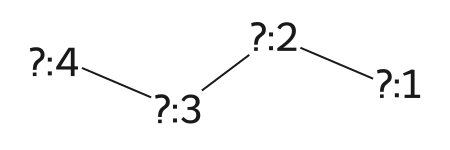

In [16]:
mol

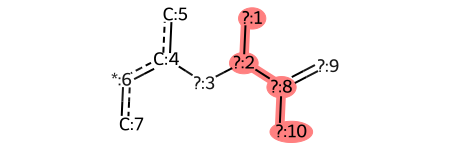

In [17]:
mol2